# Siamese Convolutional Network

## Main functions

In [2]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing import image
from keras.layers import Flatten, Reshape, UpSampling2D, Conv2D
from keras.layers import Dense, Activation, MaxPooling2D, Dropout
from keras import backend as K
%tensorflow_version 1.x
import tensorflow as tf

import cv2
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot
import time

Using TensorFlow backend.


In [0]:
def prepare_model(model):
    '''Prepares a popular model with pre-trained weights
    '''

    pre_model = model(weights='imagenet', include_top=False, input_shape=(width,height,3))
    flatten = Flatten()(pre_model.output)
    model = Model(input = pre_model.input, output = flatten)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [0]:
def compute_feature_distance(image_folder, frames, frame_step, model):
    ''' Load images, predict using the chosen model, compute and return feature distances
    '''

    counter = 0         # counts iterations
    feat_dist_arr = np.array([])        # holds feature distances

    while counter < (frames - frame_step):
        # Load and preprocess two images
        img_a_path = '{0}{1}frame{2}.jpg'.format(main_path, image_folder, counter)
        img_b_path = '{0}{1}frame{2}.jpg'.format(main_path, image_folder, counter + frame_step)

        # Load images and convert to arrays
        img_a = image.img_to_array(image.load_img(img_a_path, target_size=(width, height)))
        img_b = image.img_to_array(image.load_img(img_b_path, target_size=(width, height)))

        # Insert a new axis to match the model requirements
        img_a = np.expand_dims(img_a, axis=0)
        img_b = np.expand_dims(img_b, axis=0)

        # Preprocess images
        img_a = preprocess_input(img_a)
        img_b = preprocess_input(img_b)

        # Predict using the chosen model
        feat_a = model.predict(img_a)
        feat_b = model.predict(img_b)

        # Compute the feature distances
        feat_dist = np.linalg.norm(feat_a - feat_b)

        # Add the feature distance to the array
        feat_dist_arr = np.append(feat_dist_arr, feat_dist)

        counter = counter + frame_step
        print('Iteration {0}'.format(counter))

    print('---=== Finished one run ===---')

    return feat_dist_arr

In [0]:
def get_average(feat_dist_arr):
    ''' Computes and returns an average of a feature distance array
    '''
    
    return np.average(feat_dist_arr)

In [0]:
def get_std(feat_dist_arr):
    ''' Computes and return standard deviation of a feature distance array
    '''
    return np.std(feat_dist_arr)

In [0]:
def cleanup(feat_dist_arr, feat_dist_avg, feat_std, thresh):
    ''' Cleanup unusually high or low values
    '''

    feat_dist_arr = feat_dist_arr[(feat_dist_arr < (feat_dist_avg + feat_std + thresh))]
    feat_dist_arr = feat_dist_arr[(feat_dist_arr > (feat_dist_avg - feat_std - thresh))]

    return feat_dist_arr

## Custom model

In [0]:
def prepare_custom_model():
    '''Prepares a custom model with pre-trained weights
    '''

    input_shape = (width, height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.load_weights('{0}weights.h5'.format(main_path), by_name=True)

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

## Visualise graphs functions

In [0]:
def visualise(seconds, pos_feat_dist_arr, neg_feat_dist_arr):
    ''' Visualise the feature distances in line graphs
    '''
    
    seconds_axis = np.arange(0,seconds)

    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=seconds_axis, y=pos_feat_dist_arr[:seconds], mode='lines', name='Breathing',
                            line = dict(width=2, color='OrangeRed')))

    fig.add_trace(go.Scatter(x=seconds_axis, y=neg_feat_dist_arr[:seconds], mode='lines', name='Nonbreathing',
                            line = dict(width=2, color='SteelBlue')))

    # Edit the layout
    fig.update_layout(
        xaxis_title='Seconds',
        yaxis_title='Feature Distance',
        paper_bgcolor='white',
        plot_bgcolor='white',
        showlegend=False,
        legend_orientation="h"
    )

    fig.update_yaxes(range=[0, 600], nticks=8, gridcolor='Gainsboro', automargin=True)
    fig.update_xaxes(range=[1, seconds], showgrid=False, nticks=20, ticks="inside", automargin=True)

    fig.show(renderer='colab')

## Visualise heatmap functions

In [0]:
def compute_indiv_feature_dist(image_folder, frame1, frame2, model):
    ''' Load images, predict using the chosen model, compute and return feature distances
    '''

    # Load and preprocess two images
    img_a_path = image_folder + frame1
    img_b_path = image_folder + frame2

    # Load images and convert to arrays
    img_a = image.img_to_array(image.load_img(img_a_path, target_size=(width, height)))
    img_b = image.img_to_array(image.load_img(img_b_path, target_size=(width, height)))

    # Insert a new axis to match the model requirements
    img_a = np.expand_dims(img_a, axis=0)
    img_b = np.expand_dims(img_b, axis=0)

    # Preprocess images
    img_a = preprocess_input(img_a)
    img_b = preprocess_input(img_b)

    # Predict using the chosen model
    feat_a = model.predict(img_a)
    feat_b = model.predict(img_b)

    # Compute the feature distances
    feat_dist_long = feat_a - feat_b

    return feat_dist_long

In [0]:
def visualise_heatmap(img_orig_path, feat_dist_arr, shape):
    ''' Visualise upsampled difference regions
    '''

    channels = int(shape / (16*16))
    feat_dist_arr = np.reshape(feat_dist_arr, (1, 16, 16, channels))

    up_model = Sequential()
    up_model.add(UpSampling2D(size=(5,5), interpolation='nearest'))
    feat_up = up_model.predict(feat_dist_arr)

    feat_dist_arr = np.ma.masked_where(feat_dist_arr <= 0, feat_dist_arr)
    feat_up = np.ma.masked_where(feat_up <= 0, feat_up)

    img_orig = image.load_img(img_orig_path, target_size=(80, 80))

    pyplot.figure(figsize=(20,20))
    pyplot.subplot(1,3,1)
    pyplot.imshow(img_orig, 'viridis', interpolation='none')
    pyplot.subplot(1,3,2)
    pyplot.imshow(feat_up[0 , : , : , 0], 'viridis', interpolation='none')
    pyplot.subplot(1,3,3)
    pyplot.imshow(img_orig, interpolation='none')
    pyplot.imshow(feat_up[0 , : , : , 0], 'viridis', interpolation='none', alpha=0.5)
    pyplot.show()

## Visualise line graph architectures

In [0]:
def visualise_line_arch(df):

    seconds = 2*len(df['vgg_p'])
    seconds_axis = np.arange(0,seconds)

    labels = np.array([])
    for col in df.columns: 
        labels = np.append(labels, col)

    colours = ['rgb(182, 118, 177)', 'rgb(182, 118, 177)', 'rgb(130, 202, 175)', 'rgb(130, 202, 175)', 'rgb(117, 192, 224)', 'rgb(117, 192, 224)', 'rgb(254, 207, 106)', 'rgb(254, 207, 106)']

    # Create traces
    fig = go.Figure()

    for i in labels: 
        if i[-1] == 'p':
            fig.add_trace(go.Scatter(x=2*seconds_axis, y=df[i][:seconds], mode='lines', name='{0}'.format(i),
                                line = dict(width=2, color=colours[df.columns.get_loc(i)])))
        else:
            fig.add_trace(go.Scatter(x=2*seconds_axis, y=df[i][:seconds], mode='lines', name='{0}'.format(i),
                                line = dict(width=2, dash='dash', color=colours[df.columns.get_loc(i)])))
        
    
        fig.add_trace(
            go.Scatter(
                x=[seconds-2],
                y=[df[i].iloc[-1]],
                mode='lines+markers+text', 
                name='test',
                cliponaxis=False,
                text=['{0}'.format(i)],
                textfont=dict(size=12),
                textposition="middle right",
                marker=dict(size=10, color=colours[df.columns.get_loc(i)])
            )
        )

    # Edit the layout
    fig.update_layout(
        xaxis_title='Seconds',
        yaxis_title='Feature Distance',
        paper_bgcolor='white',
        plot_bgcolor='white',
        showlegend=False,
        legend_orientation="h"
    )

    fig.update_yaxes(range=[100, 350], nticks=8, gridcolor='Gainsboro', automargin=True)
    fig.update_xaxes(range=[1, seconds], showgrid=False, nticks=20, ticks="inside", automargin=True)

    fig.show(renderer='colab')

In [0]:
def visualise_avg_arch(df):

    seconds = len(df['vgg_p'])
    seconds_axis = np.arange(0,seconds)

    labels = np.array([])
    for col in df.columns: 
        labels = np.append(labels, col)

    colours = ['rgb(182, 118, 177)', 'rgb(182, 118, 177)', 'rgb(130, 202, 175)', 'rgb(130, 202, 175)', 'rgb(117, 192, 224)', 'rgb(117, 192, 224)', 'rgb(254, 207, 106)', 'rgb(254, 207, 106)']

    # Create traces
    fig = go.Figure()

    for i in labels:
        if i[-1] == 'p':
            fig.add_trace(go.Scatter(x=seconds_axis, y=seconds * [df[i][:seconds].mean()], mode='lines', name='{0}'.format(i),
                                line = dict(width=2, color=colours[df.columns.get_loc(i)])))
        else:
            fig.add_trace(go.Scatter(x=seconds_axis, y=seconds * [df[i][:seconds].mean()], mode='lines', name='{0}'.format(i),
                                line = dict(width=2, dash='dash', color=colours[df.columns.get_loc(i)])))


        fig.add_trace(
            go.Scatter(
                x=[seconds-1],
                y=[df[i][:seconds].mean()],
                mode='lines+markers+text', 
                name='test',
                cliponaxis=False,
                text=['{0}'.format(i)],
                textfont=dict(size=12),
                textposition="middle right",
                marker=dict(size=10, color=colours[df.columns.get_loc(i)])
            )
        )

    # Edit the layout
    fig.update_layout(
        xaxis_title='Seconds',
        yaxis_title='Feature Distance',
        paper_bgcolor='white',
        plot_bgcolor='white',
        showlegend=False,
        legend_orientation="h"
    )

    fig.update_yaxes(range=[100, 350], nticks=8, gridcolor='Gainsboro', automargin=True)
    fig.update_xaxes(range=[1, seconds], showgrid=False, nticks=20, ticks="inside", automargin=True)

    fig.show(renderer='colab')

## Run

### Main code

In [0]:
# Initial prep
main_path = '/content/drive/My Drive/Masters/Colab Notebooks/Research Code/data/'
width, height = 512, 512
frames = 120
frame_step = 2
seconds = 120
model_name = VGG16
model_str = 'VGG16'
pos = 'positive-night/frames-2min-edited/'
# pos = 'positive-night/frames-1m/'
# neg = 'negative-night/frames-1m/'
# pos_d = 'positive-daylight/frames-1m/'
# neg_d = 'negative-daylight/frames-1m/'
t0 = time.time()

In [0]:
model = prepare_model(model_name)
# model = prepare_custom_model()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`



In [0]:
pos_feat_dist_arr = compute_feature_distance(pos, frames, frame_step, model)
# neg_feat_dist_arr = compute_feature_distance(neg, frames, frame_step, model)

Iteration 2
Iteration 4
Iteration 6
Iteration 8
Iteration 10
Iteration 12
Iteration 14
Iteration 16
Iteration 18
Iteration 20
Iteration 22
Iteration 24
Iteration 26
Iteration 28
Iteration 30
Iteration 32
Iteration 34
Iteration 36
Iteration 38
Iteration 40
Iteration 42
Iteration 44
Iteration 46
Iteration 48
Iteration 50
Iteration 52
Iteration 54
Iteration 56
Iteration 58
Iteration 60
Iteration 62
Iteration 64
Iteration 66
Iteration 68
Iteration 70
Iteration 72
Iteration 74
Iteration 76
Iteration 78
Iteration 80
Iteration 82
Iteration 84
Iteration 86
Iteration 88
Iteration 90
Iteration 92
Iteration 94
Iteration 96
Iteration 98
Iteration 100
Iteration 102
Iteration 104
Iteration 106
Iteration 108
Iteration 110
Iteration 112
Iteration 114
Iteration 116
Iteration 118
---=== Finished one run ===---


In [0]:
t1 = time.time()

In [0]:
pos_feat_std = get_std(pos_feat_dist_arr)
# neg_feat_std = get_std(neg_feat_dist_arr)

In [0]:
pos_feat_dist_avg = get_average(pos_feat_dist_arr)
# neg_feat_dist_avg = get_average(neg_feat_dist_arr)

In [0]:
pos_feat_dist_arr = cleanup(pos_feat_dist_arr, pos_feat_dist_avg, pos_feat_std, 30)
# neg_feat_dist_arr = cleanup(neg_feat_dist_arr, neg_feat_dist_avg, neg_feat_std, 30)

In [0]:
np.savetxt('{0}features/{1}_{2}_{3}_2m_pos.csv'.format(main_path, model_str, width, frame_step), pos_feat_dist_arr, delimiter=',')
# np.savetxt('{0}features/{1}_{2}_{3}_neg.csv'.format(main_path, model_str, width, frame_step), neg_feat_dist_arr, delimiter=',')

In [0]:
print(np.round(pos_feat_dist_avg))
print(np.round(neg_feat_dist_avg))
print(t1 - t0)

191.0
2.0
98.08543062210083


### Visualise graphs

In [0]:
visualise(seconds, pos_feat_dist_arr, neg_feat_dist_arr)

### Visualise heatmap

In [0]:
feat_dist_long = compute_indiv_feature_dist(main_path + pos, 'frame26.jpg', 'frame27.jpg', model)

In [0]:
feat_flat_length = feat_dist_long.shape[1]
print(feat_flat_length)

327680


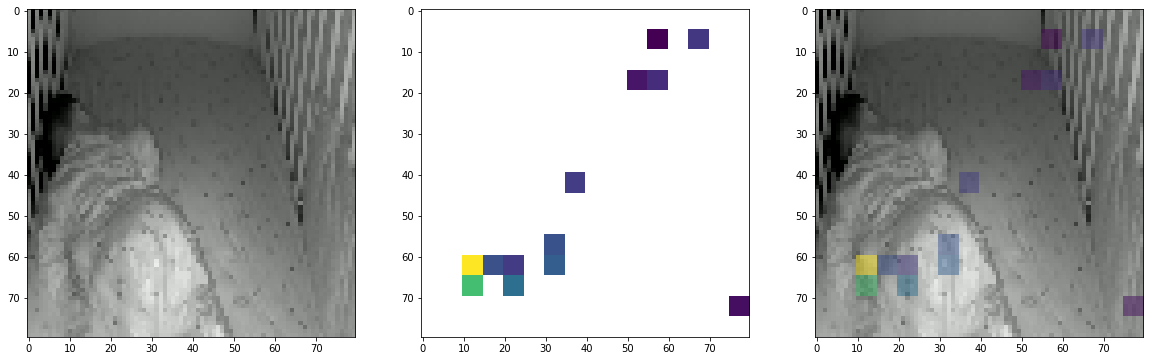

In [0]:
visualise_heatmap(main_path + pos + 'frame11.jpg', feat_dist_long, feat_flat_length)

### Visualise architectures

In [0]:
path_to_features = '{0}features/'.format(main_path)

# Load and save data
data = {
    'vgg_p':np.genfromtxt('{0}VGG16_512_2_2m_pos.csv'.format(path_to_features), delimiter=','),
    # 'vgg_n':np.genfromtxt('{0}VGG16_512_2_neg.csv'.format(path_to_features), delimiter=','),
    # 'resnet_p':np.genfromtxt('{0}ResNet50_512_2_pos.csv'.format(path_to_features), delimiter=','),
    # 'resnet_n':np.genfromtxt('{0}ResNet50_512_2_neg.csv'.format(path_to_features), delimiter=','),
    # 'custom_p':np.genfromtxt('{0}Custom_512_2_pos.csv'.format(path_to_features), delimiter=','),
    # 'custom_n':np.genfromtxt('{0}Custom_512_2_neg.csv'.format(path_to_features), delimiter=','),
    # 'mobilenet_p':np.genfromtxt('{0}MobileNetV2_512_2_pos.csv'.format(path_to_features), delimiter=','),
    # 'mobilenet_n':np.genfromtxt('{0}MobileNetV2_512_2_neg.csv'.format(path_to_features), delimiter=',')
}

df = pd.DataFrame(data)
# df['custom_p'] = 200*df['custom_p']
# df['custom_n'] = 200*df['custom_n']

visualise_line_arch(df)
visualise_avg_arch(df)